<a href="https://colab.research.google.com/github/ayulockin/TF-MSN/blob/main/notebooks/MSN_Data_Pipeline.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install -qq wandb

     |████████████████████████████████| 1.8 MB 7.5 MB/s 
     |████████████████████████████████| 157 kB 72.5 MB/s 
     |████████████████████████████████| 181 kB 62.4 MB/s 
     |████████████████████████████████| 63 kB 2.0 MB/s 
     |████████████████████████████████| 157 kB 74.8 MB/s 
     |████████████████████████████████| 157 kB 75.0 MB/s 
     |████████████████████████████████| 157 kB 81.4 MB/s 
     |████████████████████████████████| 156 kB 76.1 MB/s 


In [2]:
#@markdown `download_dataset` and `preprocess_dataframe` to be imported as `from msn.data import *`.
import wandb
import os
import glob
import json
import pandas as pd
from tqdm import tqdm


def download_dataset(dataset_name: str,
                    dataset_type: str,
                    version: str='latest',
                    save_at='artifacts/'):
    """
    Utility function to download the data saved as W&B artifacts and return a dataframe
    with path to the dataset and associated label.

    Args:
        dataset_name (str): The name of the dataset - `train`, `val`, `test`, `out-class`, and `in-class`.
        dataset_type (str): The type of the dataset - `labelled-dataset`, `unlabelled-dataset`.
        version (str): The version of the dataset to be downloaded. By default it's `latest`,
            but you can provide different version as `vX`, where, X can be 0,1,...
            
        Note that the following combination of dataset_name and dataset_type are valid:
            - `train`, `labelled-dataset`
            - `val`, `labelled-dataset`
            - `test`, `labelled-dataset`
            - `in-class`, `unlabelled-dataset`
            - `out-class`, `unlabelled-dataset`

    Return:
        df_data (pandas.DataFrame): Dataframe with path to images with associated labels if present.
    """
    if dataset_name == 'train' and os.path.exists(save_at+'train.csv'):
        data_df = pd.read_csv(save_at+'train.csv')
    elif dataset_name == 'val' and os.path.exists(save_at+'valid.csv'):
        data_df = pd.read_csv(save_at+'valid.csv')
    elif dataset_name == 'test' and os.path.exists(save_at+'test.csv'):
        data_df = pd.read_csv(save_at+'test.csv')
    # TODO (ayulockin): unlabelled dataset
    else:
        data_df = None
        print('Downloading dataset...')

    if data_df is None:
        # Download the dataset.
        wandb_api = wandb.Api()
        artifact = wandb_api.artifact(f'ayush-thakur/ssl-study-data/{dataset_name}:{version}', type=dataset_type)
        artifact_dir = artifact.download()

        # Open the W&B table downloaded as a json file.
        json_file = glob.glob(artifact_dir+'/*.json')
        assert len(json_file) == 1
        with open(json_file[0]) as f:
            data = json.loads(f.read())
            assert data['_type'] == 'table'
            columns = data['columns']
            data = data['data']

        # Create a dataframe with path and label
        df_columns = ['image_id', 'image_path', 'width', 'height']
        if 'label' in columns:
            df_columns+=['label']
        data_df = pd.DataFrame(columns=df_columns)

        for idx, example in tqdm(enumerate(data)):
            image_id = int(example[0])
            image_dict = example[1]
            image_path = os.path.join(artifact_dir, image_dict.get('path'))
            height = image_dict.get('height')
            width = image_dict.get('width')

            df_data = [image_id, image_path, width, height]
            if 'label' in columns:
                df_data+=[example[2]]
            data_df.loc[idx] = df_data

    # Shuffle the dataframe
    if dataset_name == 'train':
        data_df = data_df.sample(frac=1, random_state=42).reset_index(drop=True)

    # Save the dataframes as csv
    if dataset_name == 'train' and not os.path.exists(save_at+'train.csv'):
        data_df.to_csv(save_at+'train.csv', index=False)

    if dataset_name == 'val' and not os.path.exists(save_at+'valid.csv'):
        data_df.to_csv(save_at+'valid.csv', index=False)

    if dataset_name == 'test' and not os.path.exists(save_at+'test.csv'):
        data_df.to_csv(save_at+'test.csv', index=False)
    # TODO (ayulockin): unlabelled dataset

    return data_df


def preprocess_dataframe(df):
    # TODO (ayulockin): take care of df without labels.
    # Remove unnecessary columns
    df = df.drop(['image_id', 'width', 'height'], axis=1)
    assert len(df.columns) == 2

    # Fix types
    df[['label']] = df[['label']].apply(pd.to_numeric)

    image_paths = df.image_path.values
    labels = df.label.values

    return image_paths, labels

In [3]:
import numpy as np
import tensorflow as tf
from functools import partial
import matplotlib.pyplot as plt

AUTOTUNE = tf.data.AUTOTUNE

# Download dataset
train_df = download_dataset('train', 'labelled-dataset')

# Preprocess the DataFrames
train_paths, train_labels = preprocess_dataframe(train_df)

print(train_paths[:5], train_labels[:5])

<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit: 

··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Downloading large artifact train:latest, 351.17MB. 3960 files... Done. 0:0:44.9
3959it [00:10, 392.37it/s]


['./artifacts/train:v0/media/images/8f8dde6b19eeeb21509d/3.jpg'
 './artifacts/train:v0/media/images/cb56b9e4f7e63007aaef/24.jpg'
 './artifacts/train:v0/media/images/ae088e32c99686f55255/9.jpg'
 './artifacts/train:v0/media/images/23584844a9829e5038bb/13.jpg'
 './artifacts/train:v0/media/images/5e94c20bdaf3aae1382e/25.jpg'] [  5  34 104  24  10]


Discarding labels.

Note to self: We will use unlabelled data for pretraining. To save time and reuse what I already have, I am building on top of labelled data.

In [4]:
AUTOTUNE = tf.data.AUTOTUNE

def decode_image(img):
    # convert the compressed string to a 3D uint8 tensor
    img = tf.image.decode_jpeg(img, channels=3)
    # Normalize image
    img = tf.image.convert_image_dtype(img, dtype=tf.float32)

    return img

def parse_data(path):
    # Parse Image
    image = tf.io.read_file(path)
    image = decode_image(image)

    return image

In [5]:
#@markdown `custom_augment` on a single batch of data to get "a" view.
import tensorflow as tf
import random


# Reference: https://github.com/ayulockin/SwAV-TF/blob/master/utils/multicrop_dataset.py

@tf.function
def gaussian_blur(image, kernel_size=23, padding='SAME'):
		sigma = tf.random.uniform((1,))* 1.9 + 0.1

		radius = tf.cast(kernel_size / 2, tf.int32)
		kernel_size = radius * 2 + 1
		x = tf.cast(tf.range(-radius, radius + 1), tf.float32)
		blur_filter = tf.exp(
			-tf.pow(x, 2.0) / (2.0 * tf.pow(tf.cast(sigma, tf.float32), 2.0)))
		blur_filter /= tf.reduce_sum(blur_filter)
		# One vertical and one horizontal filter.
		blur_v = tf.reshape(blur_filter, [kernel_size, 1, 1, 1])
		blur_h = tf.reshape(blur_filter, [1, kernel_size, 1, 1])
		num_channels = tf.shape(image)[-1]
		blur_h = tf.tile(blur_h, [1, 1, num_channels, 1])
		blur_v = tf.tile(blur_v, [1, 1, num_channels, 1])
		expand_batch_dim = image.shape.ndims == 3
		if expand_batch_dim:
			image = tf.expand_dims(image, axis=0)
		blurred = tf.nn.depthwise_conv2d(
			image, blur_h, strides=[1, 1, 1, 1], padding=padding)
		blurred = tf.nn.depthwise_conv2d(
			blurred, blur_v, strides=[1, 1, 1, 1], padding=padding)
		if expand_batch_dim:
			blurred = tf.squeeze(blurred, axis=0)
		return blurred

@tf.function
def color_jitter(x, s=0.5):
		x = tf.image.random_brightness(x, max_delta=0.8*s)
		x = tf.image.random_contrast(x, lower=1-0.8*s, upper=1+0.8*s)
		x = tf.image.random_saturation(x, lower=1-0.8*s, upper=1+0.8*s)
		x = tf.image.random_hue(x, max_delta=0.2*s)
		return x

@tf.function
def color_drop(x):
		x = tf.image.rgb_to_grayscale(x)
		x = tf.tile(x, [1, 1, 3])
		return x

@tf.function
def resize_view(x, mode='random'):
		if mode == 'random':
				resize_dim = [224, 224]
		elif mode == 'focal':
				resize_dim = [96, 96]
		else:
				NotImplementedError("wrong mode passed!")
		
		# resize the image to the desired size
		x = tf.image.resize(x, resize_dim, method='bicubic', 
												preserve_aspect_ratio=False)

		return x

@tf.function
def random_apply(func, x, p):
		return tf.cond(
				tf.less(tf.random.uniform([], minval=0, maxval=1, dtype=tf.float32),
						tf.cast(p, tf.float32)),
				lambda: func(x),
				lambda: x)

@tf.function
def custom_augment(image, mode="random"):
		# Resize view
		# The official implementation uses RandomResizedCrop for resizing the view to specific size.
		# But resize operation is done before any other augmentation.
		# https://github.com/facebookresearch/msn/blob/4388dc1eadbe3042b85d3296d41b9b207656e043/src/data_manager.py#L86
		image = resize_view(image, mode)
		# Random flips
		image = random_apply(tf.image.flip_left_right, image, p=0.5)
		# Randomly apply gausian blur
		image = random_apply(gaussian_blur, image, p=0.5)
		# Randomly apply transformation (color distortions) with probability p.
		image = random_apply(color_jitter, image, p=0.8)
		# Randomly apply grayscale
		image = random_apply(color_drop, image, p=0.2)
		image = tf.clip_by_value(image, 0.0, 1.0)

		return image

## Method 1

Taking 51 seconds per batch.
Reduced to 48 seconds per batch.

In [6]:
@tf.function
def get_anchor_target_pair(image, focal_view=True, num_focal_views=5):
    # Prepare target view
    target_view = custom_augment(image)
    # Prepare anchor view for random masking
    random_anchor_view = custom_augment(image)

    return_dict = {
        "random_anchor_view": random_anchor_view,
        "target_view": target_view
    }

    # Prepare anchor view for focal masking
    if focal_view:
        focal_views = []
        for _ in range(num_focal_views):
            focal_views.append(custom_augment(image, mode="focal"))
        focal_views = tf.concat(focal_views, axis=-1)

        return_dict["focal_anchor_view"] = focal_views

    return return_dict

In [42]:
# Experimental options
options = tf.data.Options()
options.experimental_optimization.noop_elimination = True
# options.experimental_optimization.map_fusion = True
options.experimental_optimization.apply_default_optimizations = True
options.experimental_deterministic = True
options.threading.max_intra_op_parallelism = 1

In [28]:
img_file_loader = tf.data.Dataset.from_tensor_slices((train_paths))

dataloader = (
    img_file_loader # get image path
    .map(parse_data, num_parallel_calls=AUTOTUNE) # parse to get actual image
    .map(get_anchor_target_pair, num_parallel_calls=AUTOTUNE) # augment to get views
    .shuffle(1024)
    .batch(8)
    .with_options(options)
    .prefetch(AUTOTUNE)
)

In [13]:
samples = next(iter(dataloader))

In [22]:
focal = samples['focal_anchor_view']
anchor = samples['random_anchor_view']
target = samples['target_view']

focal.shape, anchor.shape, target.shape

(TensorShape([8, 96, 96, 15]),
 TensorShape([8, 224, 224, 3]),
 TensorShape([8, 224, 224, 3]))

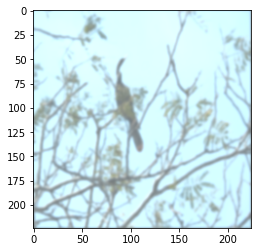

In [23]:
plt.imshow(target[0])

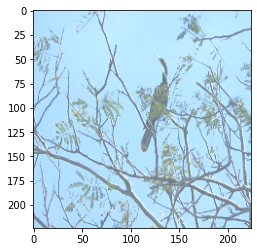

In [24]:
plt.imshow(anchor[0])

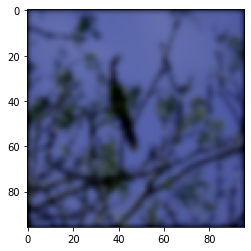

In [25]:
plt.imshow(focal[0][..., 0:3])

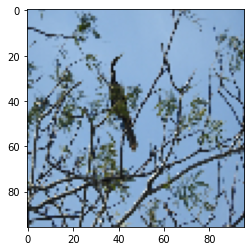

In [26]:
plt.imshow(focal[0][..., 3:6])

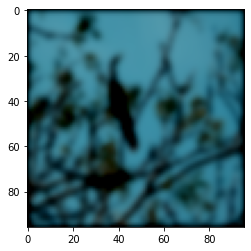

In [27]:
plt.imshow(focal[0][..., 6:9])

## Method 2

Taking only 5 seconds. It can take only 1 second if I remove the `.shuffle()`. Using a smaller buffer improves the speed.

In [71]:
img_file_loader = tf.data.Dataset.from_tensor_slices((train_paths))

dataloader = (
    img_file_loader
    .map(parse_data, num_parallel_calls=AUTOTUNE)
)

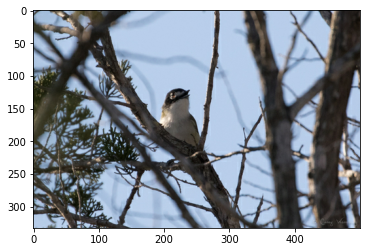

In [44]:
plt.imshow(next(iter(dataloader)))

In [72]:
def multiview_dataset(dataset,
    size_crops,
    num_crops,
    options=None):
    loaders = tuple()
    for i, num_crop in enumerate(num_crops):
      if size_crops[i] == 224:
          mode="random"
      else:
          mode="focal"
      for _ in range(num_crop):
        loader = (
            dataset
            .map(lambda x: custom_augment(x, mode=mode), num_parallel_calls=AUTOTUNE)
        )
        if options!=None:
          loader = loader.with_options(options)
        loaders += (loader, )

    return loaders

In [73]:
loaders = multiview_dataset(dataloader, [224,96], [2,5], options=options)

In [74]:
# Zipping 
loaders_zipped = tf.data.Dataset.zip(loaders)

# Final trainloader
loaders_zipped = (
    loaders_zipped
    .shuffle(100)
    .batch(8)
    .prefetch(AUTOTUNE)
)

In [75]:
samples = next(iter(loaders_zipped))

In [76]:
samples[0].shape, samples[1].shape, samples[2].shape

(TensorShape([8, 224, 224, 3]),
 TensorShape([8, 224, 224, 3]),
 TensorShape([8, 96, 96, 3]))

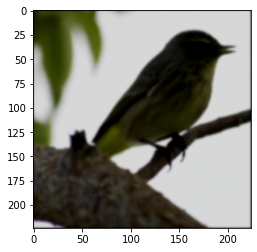

In [77]:
plt.imshow(samples[0][0])

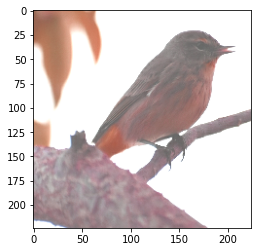

In [78]:
plt.imshow(samples[1][0])

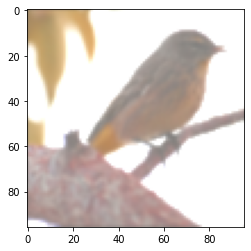

In [79]:
plt.imshow(samples[2][0])